In [1]:
import pandas as pd
import numpy as np
from tensorflow.python.ops import nn_ops, gen_nn_ops
import tensorflow as tf

In [2]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
class CNN_MC_dropout:
    def __init__(self, std=0.01, batch_size=64,width=500, height =1, input_channel=3, nb_classes=2, l_rate =1e-6,reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y = tf.placeholder(tf.float32, [None, self.nb_classes], name='y')
            self.x = tf.placeholder(tf.float32, [None, self.height,self.width,self.input_channel], name='x')
            self.keep_prob = tf.placeholder(tf.float32)
            self.is_dropout = tf.placeholder(tf.bool)
        
        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits)
        self.cost =tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.round(self.prediction),self.y)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.input = self.x
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.layers.conv2d(self.input, 128, [8,1], padding='SAME')
            self.batch1 = tf.layers.batch_normalization(self.conv1)
            self.relu1 = tf.nn.relu(self.batch1)
            self.dropout1 = tf.nn.dropout(self.relu1, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.layers.conv2d(self.dropout1, 256, [5,1], padding='SAME')
            self.batch2 = tf.layers.batch_normalization(self.conv2)
            self.relu2 = tf.nn.relu(self.batch2)
            self.dropout2 = tf.nn.dropout(self.relu2, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.layers.conv2d(self.dropout2, 128, [3,1], padding='SAME')
            self.batch3 = tf.layers.batch_normalization(self.conv3)
            self.relu3 = tf.nn.relu(self.batch3)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            #Global Average Pooling
            self.GAP = tf.reduce_mean(self.relu3, axis=[1,2])# b,h,w,c
            self.logits = tf.layers.dense(self.GAP,self.nb_classes)
            self.prediction = tf.nn.softmax(self.logits)
            
        return self.logits


    def train(self, data, target, keep_prob,is_dropout):
        opt, cost ,acc = self.sess.run((self.optimizer, self.cost, self.accuracy ), 
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def test(self, data, target, keep_prob,is_dropout):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def get_last_conv_output(self, data, keep_prob,is_dropout):
        relu3 =  self.sess.run((self.relu3), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return relu3
    
    def predict(self, data, keep_prob,is_dropout):

        prediction =  self.sess.run((self.prediction), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph() 

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [4]:
import os
from scipy.io import arff
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
data = arff.loadarff('./data/EEG-Eye-State-Dataset.arff')
df = pd.DataFrame(data[0]).values
X, y = df[:, 0:14], df[:,-1]

reshapedX = []
reshapedY = []
for i in range(len(X)):
  if i < len(X)-117:
    reshapedX.append(X[i:i+117, :])
    reshapedY.append(y[i+116])

reshapedX = np.array(reshapedX, dtype=np.float64)
reshapedY = np.array(reshapedY, dtype=np.int64)
reshapedY = reshapedY.reshape(reshapedY.shape[0],1)
print(reshapedX.shape, reshapedY.shape)

(14863, 117, 14) (14863, 1)


In [6]:
trainx, testx, trainy, testy = train_test_split(reshapedX, reshapedY, test_size=0.33, random_state=321)
batch_size = min(int(trainx.shape[0]/10), 16)
print ("batch size:{}".format(batch_size))
print(trainx.shape, trainy.shape)
print(testx.shape, testy.shape)

batch size:16
(9958, 117, 14) (9958, 1)
(4905, 117, 14) (4905, 1)


In [7]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (9958, 2)
y test shape: (4905, 2)


In [8]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train

validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]

testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(9958, 1, 117, 14)
trainY shape:(9958, 2)
validX shape:(2452, 1, 117, 14)
validY shape:(2452, 2)
testX shape:(2453, 1, 117, 14)
testY shape:(2453, 2)


In [9]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 117
input_channel 14


# 2. Training condition 정의

In [10]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 500


std= 0.01
l_rate = 1e-5

In [11]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [12]:
from numpy import unique
nb_classes =trainY.shape[1]
print (nb_classes)

2


In [13]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.


In [14]:
print (MC_dropout_model.input)
print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)

print ('[layer4]')
print (MC_dropout_model.GAP)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 117, 14), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer1/dropout/mul_1:0", shape=(?, 1, 117, 128), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 117, 256), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 117, 256), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 117, 256), dtype=float32)
Tensor("layer2/dropout/mul_1:0", shape=(?, 1, 117, 256), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer3/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 117, 128), dtype=float32)
[layer4]
Tensor("layer4/Mean:0", shape=(?, 128)

# 4. Training

In [15]:
import time

In [16]:
save_path = 'model'
model_name = 'EEG'
print (model_name)

EEG


In [17]:
def get_batch(X, Y,  batch_size=1024, shuffle=False):
    """
    dataset: numpy ndarray. dim=2
    
    dataset_input = normalized_data[:, input_idx]
    dataset_target = normalized_data[:, target_idx]
    interested_indices = train_indices
    """    
    assert np.isnan(X).any()==False
    assert np.isnan(Y).any()==False
    
    interested_indices = range(0,len(X))

    if shuffle:
        np.random.shuffle(interested_indices)
        
    for i in range(0, len(X)-batch_size, batch_size):
        batch_Xlist = []
        batch_Ylist = [] 
        
        batch_indices = interested_indices[i:i+batch_size]

        batch_Xlist.append(X[batch_indices])
        batch_Ylist.append(Y[batch_indices])

            
        batch_Xlist = np.asarray(batch_Xlist)
        batch_Xlist = batch_Xlist.reshape(-1,X.shape[1],X.shape[2],X.shape[3])
        
        batch_Ylist = np.asarray(batch_Ylist)
        batch_Ylist = batch_Ylist.reshape(-1,nb_classes)

        yield batch_Xlist, batch_Ylist

In [18]:
keep_prob =1.0

for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


train_history.to_csv(os.path.join(save_path, model_name, "history_train.csv"))
valid_history.to_csv(os.path.join(save_path, model_name, "history_valid.csv"))

# 5.check the result

### with loss and accuracy graph

In [19]:
train_history = pd.read_csv(os.path.join(save_path, model_name, "history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path, model_name, "history_valid.csv"),index_col=0)

In [20]:
import matplotlib.pyplot as plt 

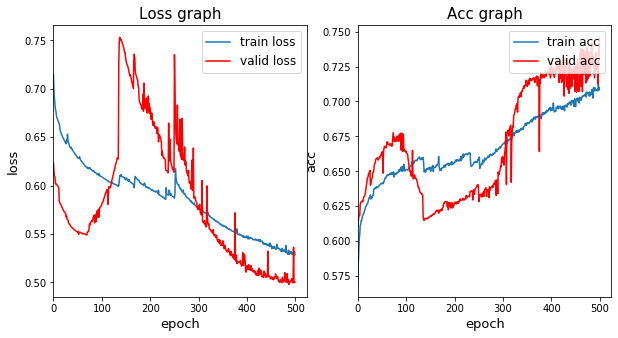

In [21]:
#Loss graph
%matplotlib inline

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train_history['loss'].tolist(), label='train loss')
ax.plot(valid_history['loss'].tolist(), label='valid loss', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Loss graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss', fontsize=13)

plt.savefig(os.path.join(save_path, model_name, 'loss_graph.png'))

ax = fig.add_subplot(1,2,2)
ax.plot(train_history['acc'].tolist(), label='train acc')
ax.plot(valid_history['acc'].tolist(), label='valid acc', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Acc graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('acc', fontsize=13)


plt.savefig(os.path.join(save_path, model_name, 'acc_graph.png'))


In [22]:
bestepoch = int(np.argmin(valid_history['loss']))

/home/sohee/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


In [23]:
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

error: 0.4978169997533162


In [24]:
bestepoch=bestepoch
MC_dropout_model.load(os.path.join(save_path, model_name,str(bestepoch)+'.ckpt'))

INFO:tensorflow:Restoring parameters from model/EEG/486.ckpt
Model restored


### with confusion matrix

In [25]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    plt.subplot(122)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()

In [26]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title='HAR classifcation(train)')

prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title='HAR classifcation(test)')

# 6. Trained 된 모델에서 Last Conv output Load하기(MC dropout적용안됨)
기존논문에서 이미지타겟으로 p(A>T)=0.005 인것과 비교하여, 시계열에서는 조금 더 낮은 threshold가 패턴을 보기에 필요함.
현재 p(A>T) = 0.05로 조정되어있음

In [27]:
import random

In [28]:
last_conv_output = MC_dropout_model.get_last_conv_output(data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]
print (last_conv_output.shape)
threshold = np.percentile(last_conv_output,99.5)
print ("threshold: {}".format(threshold))

(9958, 117, 128)
threshold: 48.583953857421875


In [29]:
last_conv_bool = last_conv_output>threshold

# 7.Result Visualization
세로축(데이터) , 가로축(마지막 컨볼루션 채널) : 데이터와 별개로 각 채널마다 일관성있게 threshold를 넘은 구간이 존재함

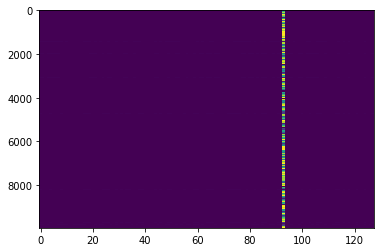

In [30]:
plt.imshow(last_conv_bool.sum(axis=1),aspect ="auto")

## pattern candidate 추출(전체길이의 10퍼센트 이상이 highlight 된 부분)

## 패턴의 연속성

In [31]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

In [32]:
from itertools import groupby
from operator import itemgetter

In [33]:
consecutive_num =trainX.shape[2]//20
consecutive_num

5

In [34]:
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]

In [35]:
consecutive_pattern=[]
for data_idx,data in enumerate(trainX[:500]):
    for output_channel_idx in survived_channel:
        pattern_bool =pd.DataFrame(last_conv_bool[data_idx][:,output_channel_idx])
        pattern_idx = [p for p, x in enumerate(last_conv_bool[data_idx][:,output_channel_idx]) if x]
        if pattern_idx:
            groups = []
            for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                if len(g)>=consecutive_num:
                    for c in range(0,data.shape[2]):
                        consecutive_pattern.append({"data_idx":data_idx, "pattern_idx":g, "pattern":data[0,g,c]})   

In [36]:
pattern_candidate = [x['pattern'] for x in consecutive_pattern]

In [46]:
len(pattern_candidate)

23086

# clustering for pattern_candidate

consecutive_pattern 에는 (data_idx, pattern_idx, pattern) 이 dictionary 형태로 들어가있습니다.
여기서 pattern만 모아 pattern_candidate에 저장되어있습니다.
pattern_candidate을 클러스터링 하면 될 것 같습니다.

pattern candidate의 길이가 매우 다양하여 이것을 어떻게 deal하면 좋을지 의논을 할 필요가 있는듯?

In [37]:
l_pattern=[]
for l in np.unique([len(x) for x in pattern_candidate]):
    l_pattern.append(len([x for x in pattern_candidate if len(x)==l]))

l_pattern_dict :패턴의 길이와 해당 길이의 패턴의 수를 매칭시켜놓은 변수

In [38]:
l_pattern_dict=dict()
for i,l in enumerate(l_pattern):
    l_pattern_dict[str(np.unique([len(x) for x in pattern_candidate])[i])]=l

In [48]:
l_pattern_candidate = np.asarray([x for x in pattern_candidate if len(x)==5])
len(l_pattern_candidate)

2856

## pattern standardization

1. pattern 원본 그대로 사용
2. 평균0, 분산1 형태로 standardization
3. 각 패턴이 0~1 사이로 min,max normalization 

1,2,3 방법 혹은 어떤 방법으로 정규화 할지를 같이 정하면 될것 같습니다.
저는 우선 2번,3번 방법으로 진행해보았습

#1. pattern 원본 그대로 사용
normalized_pattern_candidate =l_pattern_candidate

#2. 평균0, 분산1 형태로 standardization
from sklearn.preprocessing import StandardScaler
normalized_pattern_candidate =StandardScaler().fit_transform(np.asarray(l_pattern_candidate))

In [49]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
normalized_pattern_candidate =TimeSeriesScalerMeanVariance().fit_transform(l_pattern_candidate)
normalized_pattern_candidate = normalized_pattern_candidate.squeeze()
normalized_pattern_candidate.shape

(2856, 5)

#3.각 패턴이 0~1 사이로 min,max normalization
normalized_pattern_candidate = (l_pattern_candidate.T - l_pattern_candidate.min(axis=1))/(l_pattern_candidate.max(axis=1)- l_pattern_candidate.min(axis=1))
normalized_pattern_candidate = normalized_pattern_candidate.T

## spectral clustering, gmm clustering,k-means,SOM

In [50]:
from sklearn import mixture,cluster
from tslearn.clustering import TimeSeriesKMeans

In [51]:
#n_cluster : interger
#eigen_solver{None, ‘arpack’, ‘lobpcg’, or ‘amg’}
#affinity: ‘nearest_neighbors’‘rbf’
default_spectral = {'n_clusters':2,
                    'eigen_solver': 'arpack',
                    'affinity': "nearest_neighbors"}

#covariance_type{‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}
default_gmm = {'n_clusters':2, 'covariance_type': 'full'}

default_kmeans = {'n_clusters':2,'verbose':False,'random_state':0}

default_hac = {'method':'single','metric':'euclidean','cut_off_level':5,'criterion':'maxclust'}

spectral_option = [
    ({'n_clusters': 3}),
    ({'n_clusters': 6})
]

gmm_option = [
    ({'n_clusters': 3}),
    ({'n_clusters': 6})
    
]

kmeans_option = [
    ({'n_clusters': 3}),
    ({'n_clusters': 6})
    
]

hac_option =[
    ({'cut_off_level': 3}),
    ({'cut_off_level': 6})
    
]

parameter 조절하며 시각화

In [52]:
import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

/home/sohee/.local/lib/python3.6/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/sohee/.local/lib/python3.6/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


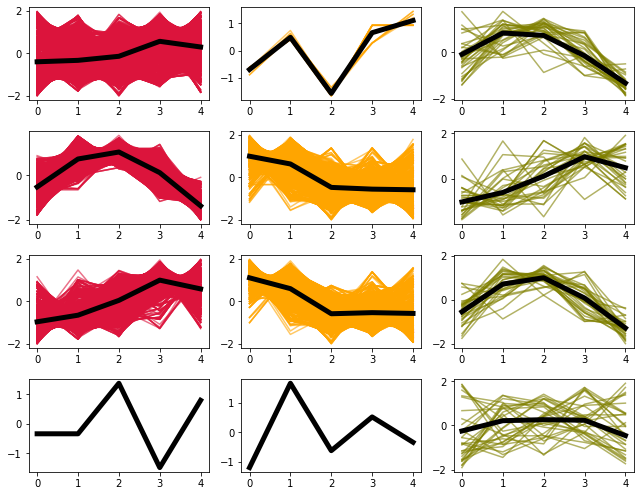

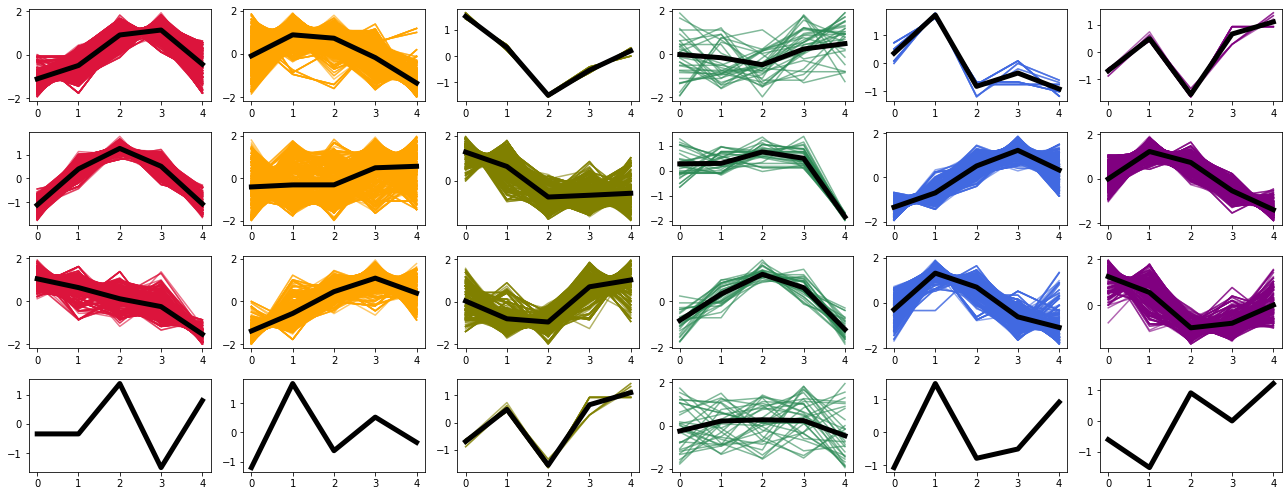

In [53]:
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]
random.seed(300)
for s_option,g_option,k_option,h_option in zip(spectral_option,gmm_option,kmeans_option,hac_option):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    
    h_params = default_hac.copy()
    h_params.update(h_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])
    
    D = hac.linkage(normalized_pattern_candidate, method=h_params['method'],metric=h_params['metric'])
    
    s_pred = spectral.fit_predict(normalized_pattern_candidate)
    g_pred = gmm.fit_predict(normalized_pattern_candidate)
    k_pred = kmeans.fit_predict(normalized_pattern_candidate)
    h_pred = hac.fcluster(D, h_params['cut_off_level'], criterion=h_params['criterion'])-1
    
    fig = plt.figure(figsize=(len(np.unique(s_pred))*3,7))
    axes = fig.subplots(4, s_params['n_clusters'])
    for class_ in range(0,s_params['n_clusters']):
        s_class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
        g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        k_class_idx = [i for i,x in enumerate(k_pred) if x ==class_]
        h_class_idx = [i for i,x in enumerate(h_pred) if x ==class_]

        try:
            axes[0,class_].plot(normalized_pattern_candidate[random.sample(s_class_idx,30)].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[random.sample(g_class_idx,30)].T, color =color[class_],alpha=0.6)
            axes[2,class_].plot(normalized_pattern_candidate[random.sample(k_class_idx,30)].T, color =color[class_],alpha=0.6)
            axes[3,class_].plot(normalized_pattern_candidate[random.sample(h_class_idx,30)].T, color =color[class_],alpha=0.6)
            
        except:
            axes[0,class_].plot(normalized_pattern_candidate[s_class_idx].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[g_class_idx].T, color =color[class_],alpha=0.6)
            axes[2,class_].plot(normalized_pattern_candidate[k_class_idx].T, color =color[class_],alpha=0.6)
            axes[3,class_].plot(normalized_pattern_candidate[h_class_idx].T, color =color[class_],alpha=0.6)
            
        axes[0,class_].plot(normalized_pattern_candidate[s_class_idx].mean(axis=0), color ='black',alpha=1,linewidth=5)
        axes[1,class_].plot(normalized_pattern_candidate[g_class_idx].mean(axis=0), color ='black',alpha=1,linewidth=5)
        axes[2,class_].plot(normalized_pattern_candidate[k_class_idx].mean(axis=0), color ='black',alpha=1,linewidth=5)
        axes[3,class_].plot(normalized_pattern_candidate[h_class_idx].mean(axis=0), color ='black',alpha=1,linewidth=5)
            
    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()

## hierarchical clustering

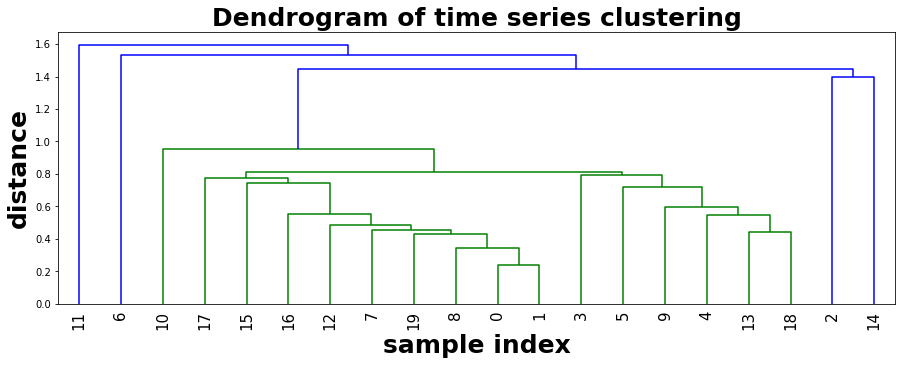

In [54]:
import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

D = hac.linkage(normalized_pattern_candidate[:20], method='single',metric='euclidean')
cut_off_level = 5
#Dendrogram
plt.figure(figsize=(15, 5))
plt.title('Dendrogram of time series clustering',fontsize=25, fontweight='bold')
plt.xlabel('sample index', fontsize=25, fontweight='bold')
plt.ylabel('distance', fontsize=25, fontweight='bold')
hac.dendrogram(D, leaf_rotation=90., leaf_font_size=15., ) # font size for the x axis labels
plt.show()

특정 파라미터에 해당하는 클러스터 시각화

# Below part is still unclear

In [55]:
import matplotlib.patheffects as pe

In [56]:
random.seed(300)
sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),len(normalized_pattern_candidate))
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

/home/sohee/.local/lib/python3.6/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


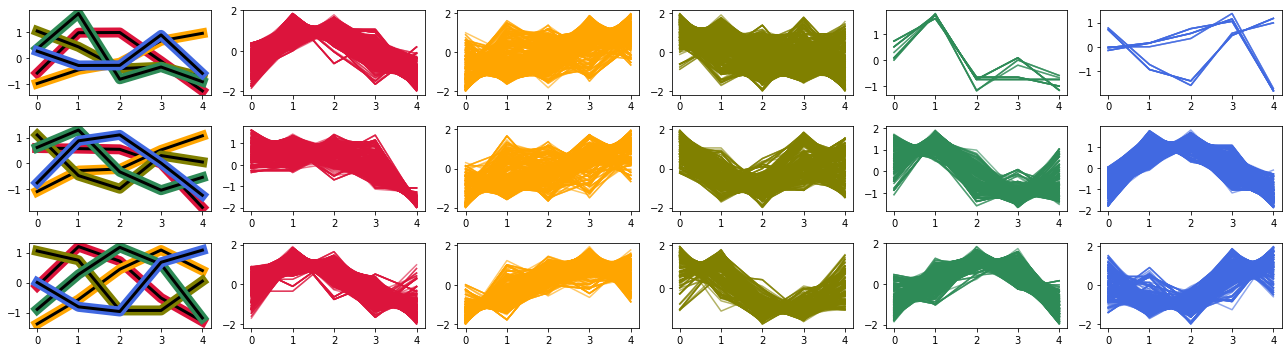

In [57]:
for s_option,g_option,k_option in zip(spectral_option[::-1],gmm_option[::-1],kmeans_option[::-1]):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])
    
    spectral.fit(normalized_pattern_candidate)
    gmm.fit(normalized_pattern_candidate)
    kmeans.fit(normalized_pattern_candidate)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    k_pred = kmeans.fit_predict(normalized_pattern_candidate[sample_data_idx])
    
    num_class = len(list(set(np.unique(s_pred)).union(set(np.unique(g_pred)))))
    fig = plt.figure(figsize=(18,5))
    axes = fig.subplots(3,num_class)    
    
    for class_ in range(0,num_class):
        class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
        try:
            axes[0][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[0][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color = 'black',alpha=1,linewidth=3,
                   path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        
        class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        try:
            axes[1][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[1][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        class_idx = [i for i,x in enumerate(k_pred) if x ==class_]
        try:
            axes[2][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[2][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()
    break

# SOM

In [58]:
import sompy

/home/sohee/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [59]:
som = sompy.SOMFactory.build(normalized_pattern_candidate, mapsize=None, normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose=False)  # verbose='debug' will print more, and verbose=None wont print anything

/home/sohee/.local/lib/python3.6/site-packages/sompy/visualization/hitmap.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


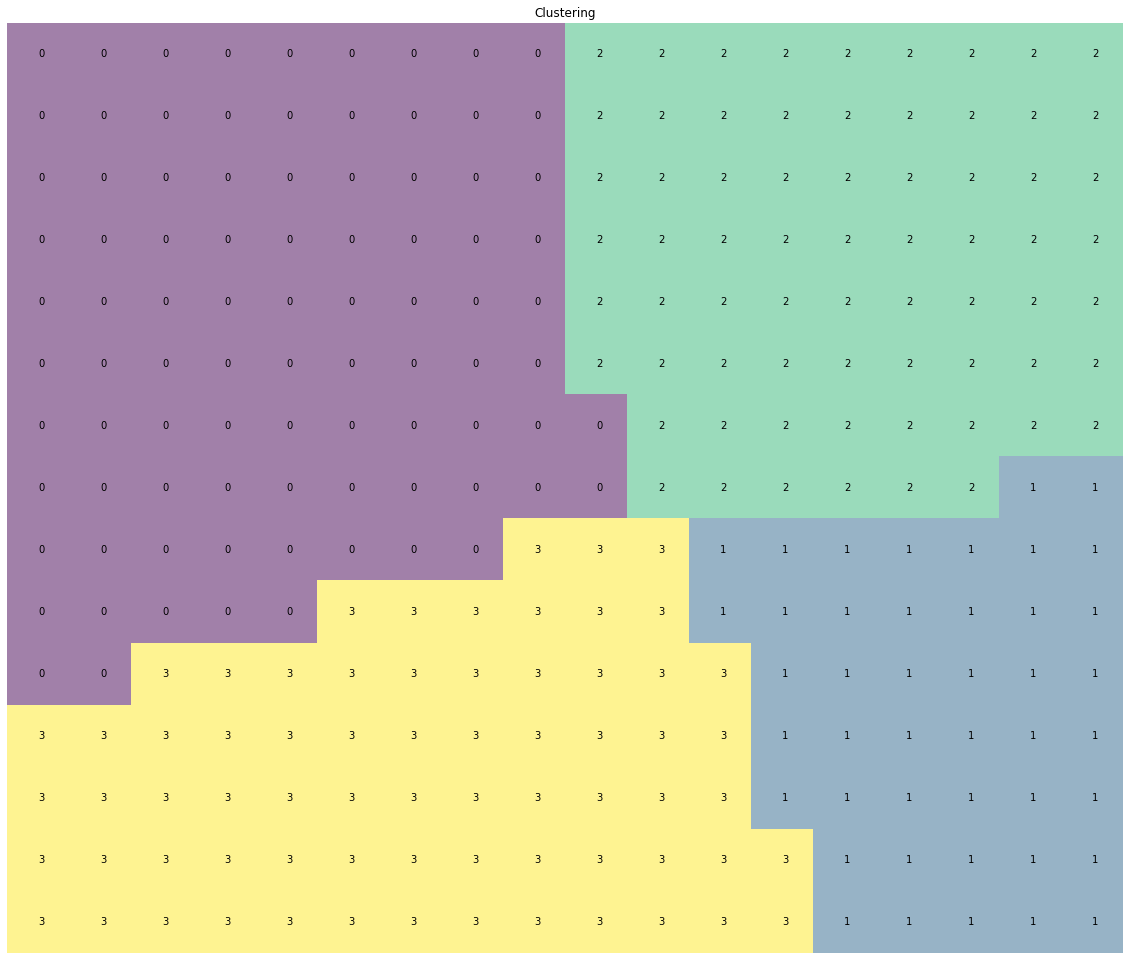

In [60]:
from sompy.visualization.hitmap import HitMapView
som.cluster(4)
hits  = HitMapView(20,20,"Clustering",text_size=12)
a=hits.show(som)

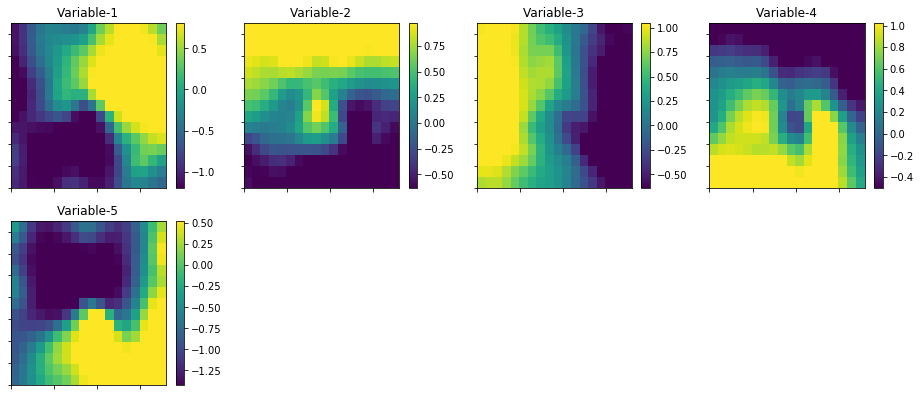

In [61]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(som, col_sz=4, which_dim="all", desnormalize=True)

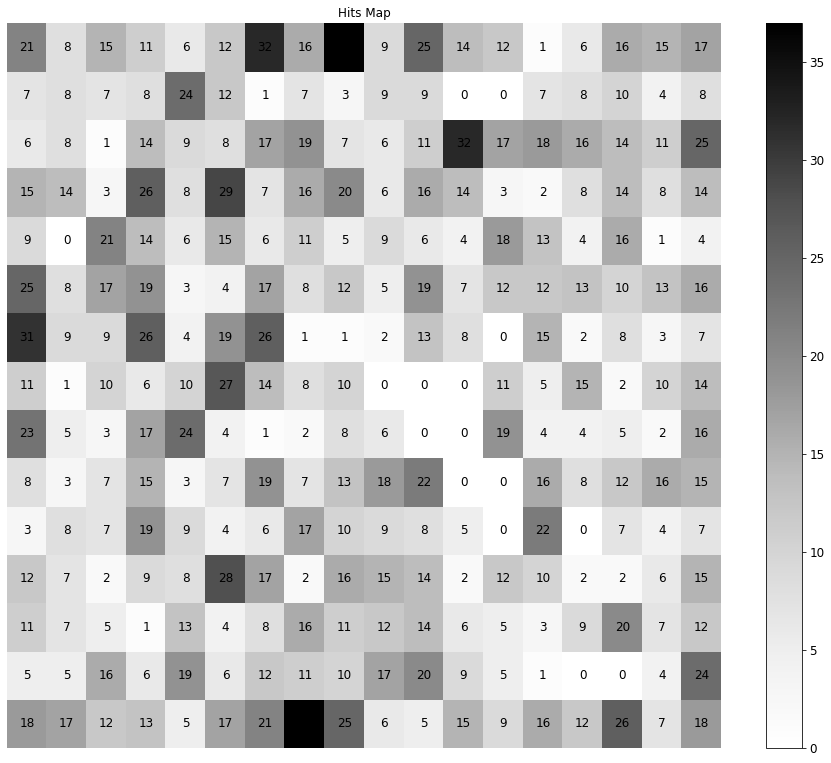

In [62]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(4,4,"Hits Map",text_size=12)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

## represent as feature vector

### 1. wavelet

In [63]:
import do_wavelet
import matplotlib.gridspec as gridspec
import pywt

ModuleNotFoundError: No module named 'do_wavelet'

In [ ]:
N = normalized_pattern_candidate[3].shape[0]
t0=10
dt=1
time = np.arange(0, N) * dt + t0
signal = normalized_pattern_candidate[3]
 
scales = np.arange(1, 128)

In [ ]:
fig = plt.figure(figsize=(12,6))
spec = gridspec.GridSpec(ncols=6, nrows=6)
top_ax = fig.add_subplot(spec[:2, 0:5])
bottom_left_ax = fig.add_subplot(spec[2:, 0:5])
bottom_right_ax = fig.add_subplot(spec[2:, 5])

plot_signal_plus_average(top_ax, time, signal, average_over = 3)
yticks, ylim = plot_wavelet(bottom_left_ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)

plot_fft_plus_power(bottom_right_ax, time, signal, plot_direction='vertical', yticks=yticks, ylim=ylim)
bottom_right_ax.set_ylabel('Period [years]', fontsize=14)
plt.tight_layout()
plt.show()

### 2. clustering time series using unsupervised shapelets

In [ ]:
D =pattern_candidate
sLen = range(6,64)

In [ ]:
S_hat={}
ts =D[15]

while True:
    cnt=0
    s_hat ={}
    gap = {} 
    dt ={}
    for sl in sLen:#each u-shapelet length
        for i in range(0, len(ts)-sl):#each subsequence from ts 
            if i+sl-1> len(ts)-1: 
                continue
            else:
                s_hat[cnt] = ts[i:i+sl-1] #a subsequence of length sl
                tup = compute_gap(s_hat[cnt],D)
                gap[cnt],dt[cnt] = tup[0],tup[1]
                cnt+=1
        try:
            index1 = np.argmax(list(gap.values()))
            S_hat = s_hat[index1] #find maximum gap score
            dis = compute_distance(s_hat[index1],D)#add the u-shapelet with max gap score
            dA= dis<dt
            if len(dA) ==1:
                break
            else:
                index2 = np.argmax(dis)
                ts = D[index2]
                msdA= np.mean(dA) +np.std(dA)
                D_hat = dis<msdA
        except:
            continue
    break

In [ ]:
np.argmax(list(gap.values()))

In [ ]:
s_hat

In [ ]:
S_hat={}
ts =D[15]
cnt=0
s_hat ={}
gap = {} 

sl = 6

In [ ]:
i=1
s_hat[cnt] = ts[i:i+sl-1]

In [ ]:
s_hat

In [ ]:
gap = [1e6]*(len(ts)-sl)

In [ ]:
set(pattern_candidate [:10]) -set(pattern_candidate[0])

In [ ]:
normalized_s = (sub-sub.min())/(sub.max()-sub.min())

In [ ]:
ts =pattern_candidate[1]

In [ ]:
dis = 10e6

In [ ]:
for j in range(0, len(ts)-len(sub)):

In [ ]:
znorm(ts[0:len(sub)])

In [ ]:
def znorm(data):
    return (data-data.min())/(data.max()-data.min())

In [ ]:
def euclidean_d(data1,data2):
    return np.linalg.norm(data1-data2)

In [ ]:
dis =compute_distance(sub,data)

In [ ]:
np.sort(dis)[::-1]

In [ ]:
compute_gap(sub,data)

In [ ]:
k=6

In [ ]:
def compute_gap(sub, data):
    dis= compute_distance(sub,data)
    dis = np.sort(dis)[::-1]
    maxGap = 0
    dt = 0
    for l in range(1, len(dis)-1-1):
        d = (dis[l]+dis[l+1])/2
        
        dA = dis[dis<d]
        dB = dis[dis>d]
        if len(dB)>0:
            r = len(dA)/len(dB)
            if ((1/k < r) and (1-(1/k))):
                mA = np.mean(dA)
                mB = np.mean(dB)
                sA = np.std(dA)
                sB = np.std(dB)
                gap = mB-sB-(mA+sA)
                if gap>maxGap :
                    maxGap =gap
                    dt =d
    return maxGap, dt

In [ ]:
def compute_distance(sub, data):
    dis=[10e6]*len(data)
    sub = znorm(sub)
    for i in range(0,len(data)):
        ts = data[i]
        if len(ts)<len(sub):
            continue
        else:
            for j in range(0, len(ts)-len(sub)):
                z = znorm(ts[j:j+len(sub)])
                d = euclidean_d(z,sub)
                dis[i]= min(d,dis[i])/np.sqrt(len(sub))
    return dis

In [ ]:
s_option =spectral_option[-1]
g_option=gmm_option[-1]
s_params = default_spectral.copy()
s_params.update(s_option)

g_params = default_gmm.copy()
g_params.update(g_option)

spectral = cluster.SpectralClustering(
    n_clusters=s_params['n_clusters'], 
    eigen_solver=s_params['eigen_solver'],
    affinity=s_params['affinity'])

gmm =  mixture.GaussianMixture(
    n_components=g_params['n_clusters'], 
    covariance_type=g_params['covariance_type'])

s_pred = spectral.fit_predict(normalized_pattern_candidate)
g_pred = gmm.fit_predict(normalized_pattern_candidate)

s_representative_pattern =[]
g_representative_pattern =[]
for class_ in np.unique(s_pred):

    s_class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
    s_representative_pattern.append(normalized_pattern_candidate[s_class_idx].mean(axis=0))

    g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
    g_representative_pattern.append(normalized_pattern_candidate[g_class_idx].mean(axis=0))


In [ ]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 2, 1,projection='3d')

x = ((g_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((g_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((g_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax.scatter(x,y,z, c = g_pred)

ax.set_xlabel('class1')
ax.set_ylabel('class2')
ax.set_zlabel('class3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#ax.axis('off')

ax2 = fig.add_subplot(1, 2, 2,projection='3d')

x = ((s_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((s_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((s_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax2.scatter(x,y,z, c = s_pred)

ax2.set_xlabel('class1')
ax2.set_ylabel('class2')
ax2.set_zlabel('class3')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]
random.seed(300)
for s_option,g_option in zip(spectral_option,gmm_option):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    s_pred = spectral.fit(normalized_pattern_candidate)
    g_pred = gmm.fit(normalized_pattern_candidate)
    
    sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),100)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    
    fig = plt.figure(figsize=(15,3))
    for class_ in np.unique(s_pred):
        ax = plt.subplot(1,2,1)
        class_idx = [sample_data_idx[i] for i,x in enumerate(s_pred) if x ==class_]
        ax.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
        ax.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)

        ax2 = plt.subplot(1,2,2)
        class_idx = [sample_data_idx[i] for i,x in enumerate(g_pred) if x ==class_]
        try:
            #ax2.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
            ax2.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)
        except:
            continue

    fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params))
    plt.tight_layout()


### plotly visualization을 위해 샘플 데이터 및 패턴 저장

In [ ]:
sample_data_idx=87
sample_output_channel = 79
sample_data = pd.DataFrame(trainX[sample_data_idx].reshape(-1,9))

In [ ]:
sample_pattern_bool =pd.DataFrame(last_conv_bool[sample_data_idx][:,sample_output_channel])
pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx][:,sample_output_channel]) if x]

In [ ]:
last_conv_bool[sample_data_idx][:,sample_output_channel].sum()

In [ ]:
groups = []
for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
    groups.append(list(g))    # Store group iterator as a list

In [ ]:
consecutive_pattern=[]
for g in groups:
    if len(g)>consecutive_num:
        consecutive_pattern.extend(g)
        
consecutive_pattern_bool=[]
for x in range(0,128):
    if x in np.asarray(consecutive_pattern).flatten():
        consecutive_pattern_bool.append(True)
    else:
        consecutive_pattern_bool.append(False)

In [ ]:
sample_consecutive_pattern_bool= pd.DataFrame(consecutive_pattern_bool)

sample_data.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_data.csv')
sample_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_pattern.csv')
sample_consecutive_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_consecutive_pattern.csv')

## 2d visualization

In [ ]:
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

DEFAULT_PLOTLY_COLORS=['rgba(31, 119, 180, {})', 'rgba(255, 127, 14, {})',
                       'rgba(44, 160, 44, {})', 'rgba(214, 39, 40, {})',
                       'rgba(148, 103, 189, {})', 'rgba(140, 86, 75, {})',
                       'rgba(227, 119, 194, {})', 'rgba(127, 127, 127, {})',
                       'rgba(188, 189, 34, {})', 'rgba(23, 190, 207, {})']

normalized_data = (sample_data.values - sample_data.values.min(axis=0))/(sample_data.values.max(axis=0) - sample_data.values.min(axis=0))
for cidx in range(0,sample_data.shape[1]):
    normalized_data[:,cidx] =normalized_data[:,cidx] + cidx 
    
    
fig = make_subplots(
    rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02
)

for cidx in range(sample_data.shape[-1]):
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0]), 
                             y=normalized_data[:,cidx],  
                            line_color="black",
                             line_width=1,
                             showlegend=False,
                             ),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0])[consecutive_pattern_bool], 
                            y=normalized_data[consecutive_pattern_bool,cidx],  
#                               fill='toself',
                            line_color='rgba(200, 0, 200, 0.6)',
                            line_width=5,
                            showlegend=False,
                            ),
                   row=1, col=1)
    
fig.update_xaxes(showline=True, linewidth=2, linecolor='black',ticks="inside")
fig.update_yaxes(showline=True, linewidth=2, linecolor='black',
                 ticks="inside",nticks=sample_data.shape[1], tickwidth=2, tickcolor='black', ticklen=10,title_text='Input Channel',
                showgrid=True, gridwidth=1, gridcolor='grey',
                ticktext=["Channel1", "Channel2", "Channel3", "Channel4","Channel5", "Channel6", "Channel7", "Channel8", "Channel9"],
                tickvals=["1", "2", "3", "4", "5", "6","7", "8", "9"],
                range=[0,9])


fig.update_layout(height=600, width=800,plot_bgcolor='rgb(256,256,256)',
                  title_text="Input")

fig.show()

## 3d visualization

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib inline
%matplotlib qt

In [ ]:
random.seed = 10005

class_color= ["cyan","orange","lime","pink","cyan","orange","lime","pink","cyan"]
consecutive_class_color= ["dodgerblue","coral","seagreen","indianred","dodgerblue","coral","seagreen","indianred","dodgerblue"]
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]
sample_channel = random.sample(survived_channel,1)

consecutive_num =trainX.shape[2]//20

for class_i in class_list:
    
    sample_data_idx =random.sample([i for i, e in enumerate(np.argmax(trainY,axis=1)) if e == (class_i-1)],1)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    fig.suptitle("Last Conv ({}) Consecutive ({}) ,Output(class{}) ".format(sample_channel,consecutive_num,class_i-1))
    
    for c in range(0,input_channel):
        data = trainX[sample_data_idx,:,:,c].reshape(-1,1)
        data = (data-data.min())/(data.max()-data.min())
        pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx[0],:,c]) if x]
        #ax = fig.gca(projection='3d')

        ax.plot([c]*len(data),range(0,len(data)), data.flatten())
        # 패턴의 연속성을 찾는 구간
        groups = []
        for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
            groups.append(list(g))    # Store group iterator as a list
        for g in groups:
            if len(g)>consecutive_num:
                ax.scatter([c]*len(g) ,g,data[g],color = consecutive_class_color[c], s =12,alpha=0.7)
                #ax.add_collection3d(plt.fill_between(np.arange(g[0],g[-1]),data[g[0]:g[-1]],0), zs=1, zdir='y')
                #ax[j].text(g[0],0,len(g))
            #else:
                #ax.scatter(g,[c]*len(g), data[g],color = class_color[c],s=12)
                
        ax.set_xticks=[]
        ax.set_yticks=[]
        #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.8, 0.2, 1]))
    break